In [1]:
import numpy as np
import sys
import gsw
import datetime as dt
from datetime import datetime 
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from xgcm import Grid 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [98]:
da_dep = xr.DataArray(data=dep, dims=["lon","lat"],
    coords=dict(lat=(["lat"], np.nanmean(lats,axis=0)),lon=(["lon"], np.nanmean(lons,axis=1))),
)

In [99]:
da_dep.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/tile10_depth_est.nc')

In [3]:
# -- mask at the surface and total ocean area -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_grid.rA*ocean_mask)
# -- Gulf of Mexico Mask -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_grid.XC.i.data), j=(["j"], ecco_grid.XC.j.data),
        XC=(["j","i"], ecco_grid.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_grid.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; 
lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# -- subdivisions -- 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan
gulf_area = np.nansum(gulf_mask*ecco_grid.rA.isel(tile=tile_num))
# -- surface and layer areas -- 
h = dep                                               # depth 
A = ecco_grid.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_grid.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 

AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [4]:
# -- load profiles -- 
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/argo_2010_2021_rho.nc')
argo_rho = xr.open_dataset(filename)
a_rho = argo_rho.rho
a_press = argo_rho.pressure
a_z = gsw.z_from_p(a_press,25)
a_lon = argo_rho.lon
a_lat = argo_rho.lat
a_time = argo_rho.time

Text(0.5, 1.0, '505')

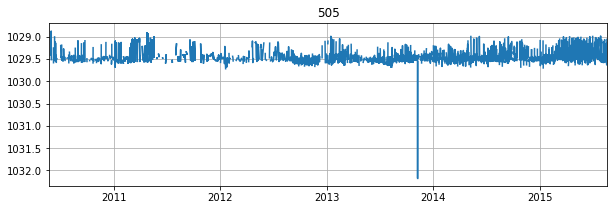

In [5]:
t_dep = 25
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(a_time,a_rho[t_dep,:])
ax.invert_yaxis()
ax.grid()
ax.set_xlim([a_time[0], a_time[4000]])
ax.set_title(str(a_press[t_dep].data))

In [6]:
# convert to ordinal time
a_time_ord = np.nan*np.ones(len(a_time))
for i in range(len(a_time)):
    ts = (np.datetime64(str(a_time[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    a_time_ord[i] = ts/(60*60*24)

In [7]:
# -- contruct monthly time record 
mo_rec = np.arange(5.5,12*12,1) # __ year monthly time series (12*#months)
t_rec = []; # t_start = np.datetime64('2010-05-15')
for i in range(len(mo_rec)):
    t_year = np.floor(mo_rec[i]/12) + 2010
    t_month = np.floor(np.mod(mo_rec[i],12)) + 1
    if t_month < 10:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-0' + str(np.int(t_month)) + '-15'))
    else:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-' + str(np.int(t_month)) + '-15'))

In [8]:
# check conversion 
print(t_rec[-1])
ts = (t_rec[-1] - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
tday = ts/(60*60*24)
print(tday)
datetime.fromordinal(int(tday)) + dt.timedelta(days=tday%1) - dt.timedelta(days=365)

2021-12-15
738504.0


datetime.datetime(2021, 12, 15, 0, 0)

In [20]:
t_rec[-1]

numpy.datetime64('2021-12-15')

In [9]:
# for each month obtain mean density profile 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t_argo = xr.DataArray(v_cell_t[0:30][:,105,230])
v_cell_z = ecco_grid.Z[0:29]                                            # depth of vertical cell center 

rho_argo = np.nan*np.ones((len(v_cell_z),len(t_rec)))
for i in range(len(t_rec)):
    ts = (t_rec[i] - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    this_time = ts/(60*60*24)
    t_in = np.where((a_time_ord > (this_time - 25)) & (a_time_ord < (this_time + 25)))[0]
    # -- average over longer times to see time scale of pattern) 
    if len(t_in) > 2:
        mean_rho = np.nanmean(a_rho[:,t_in],axis=1)
        good = np.where(~np.isnan(mean_rho))[0]
        # interpolate in the vertical to ECCO grid (for areas)
        rho_argo[:,i] = np.interp(-1*v_cell_z.data,\
                                  -1*a_z[good],mean_rho[good]) 
        

Text(0.5, 1.0, '-350.68')

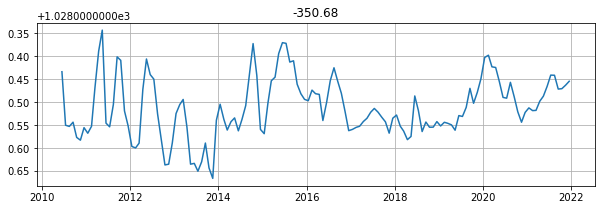

In [10]:
t_dep = 20
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t_rec,rho_argo[t_dep,:])
ax.invert_yaxis()
ax.grid()
# ax.set_xlim([t_rec[0], t_rec[20]])
ax.set_title(str(v_cell_z[t_dep].data))

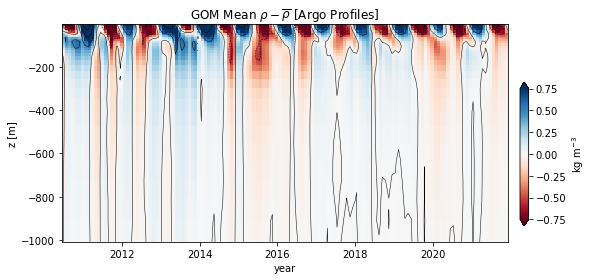

In [27]:
rhobar = np.nanmean(rho_argo[0:29,:],axis=1)
f, ax = plt.subplots(1,1,figsize=(8,4))
pp = ax.pcolor(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))), cmap='RdBu', vmin=-0.75, vmax=0.75)
ax.contour(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))), level=[0], linewidths=0.5, colors='k')
ax.set_title(r'GOM Mean $\rho - \overline{\rho}$ [Argo Profiles]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); ax.set_xlim([t_rec[0], t_rec[-1]])
cbpos = [0.92, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')

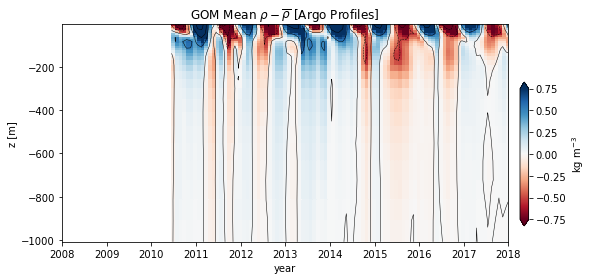

In [30]:
f, ax = plt.subplots(1,1,figsize=(8,4))
pp = ax.pcolor(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))), cmap='RdBu', vmin=-0.75, vmax=0.75)
ax.contour(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))), level=[0], linewidths=0.5, colors='k')
ax.set_title(r'GOM Mean $\rho - \overline{\rho}$ [Argo Profiles]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); 
ax.set_xlim([np.datetime64('2008-01-01T00:00:00Z'), np.datetime64('2018-01-01T00:00:00Z')])
# ax.set_xlim([t_rec[0], t_rec[-1]])
cbpos = [0.92, 0.18, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')

In [45]:
z_i = np.arange(0,29)
t_i = np.arange(0,len(t_rec))
rho_argo_s = rho_argo[z_i,:][:,t_i] 
den_eg_da = xr.Dataset(
    data_vars=dict(
        rho=(['month','layer'], np.transpose(rho_argo_s)),
        v_cell_thick=(['layer'], v_cell_t_argo[z_i].data),
        AAi_Argo=(['layer'], AAi[z_i].data),
        time=(['month'], t_rec[t_i[0]:])
    ),
    coords=dict(
        month=(["month"], t_i),
        layer=(["layer"], z_i)
    ),
)

In [46]:
# -- Run Landerer Model -- 
# constants 
g = 9.81 
rho0 = 1035
delta_pb_total = np.nan*np.ones((np.shape(den_eg_da.rho)[0],np.shape(den_eg_da.rho)[1]))
lay1 = np.nan*np.ones((np.shape(den_eg_da.rho)[0]))
layb = np.nan*np.ones((np.shape(den_eg_da.rho)[0],len(v_cell_z)-1))
for tt in range(np.shape(den_eg_da.rho)[0]):                            # loop over all times 
    for m in range(0,29):                                               # loop over all layers 
        this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
        this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (den_eg_da.AAi_Argo.isel(layer=below_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=below_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=below_i))).sum(dim='layer')
        above = (1/rho0)*((As/den_eg_da.AAi_Argo.isel(layer=above_i) - 1)*(den_eg_da.AAi_Argo.isel(layer=above_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=above_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=above_i))).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data

# output as data array 
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data),
                            time=(["time"], den_eg_da.time.data),
                        ),
                       )

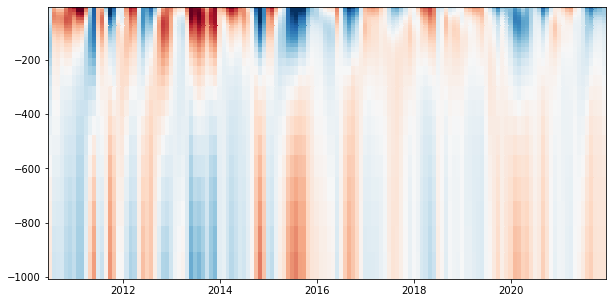

In [47]:
test = deltapbz_total - deltapbz_total.mean(dim=['time'])
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.pcolor(deltapbz_total.time,v_cell_z,test.data, cmap='RdBu', vmin=-0.1, vmax=0.1)

In [48]:
den_eg_da.time[0].data

array('2010-06-15T00:00:00.000000000', dtype='datetime64[ns]')

In [49]:
# t_s = str(den_eg_da.time[0].data) # '2010-01-15' # 
# t_e = str(den_eg_da.time[-1].data) # '2017-12-15' # str(t_rec[-1])
t_s = str(den_eg_da.time[0].data) # '2010-06-01'
t_e = '2017-12-15'
test = (deltapbz_total.sel(time=slice(t_s, t_e)) - deltapbz_total.sel(time=slice(t_s, t_e)).mean(dim=['time']))
# test = deltapbz_total - deltapbz_total.mean(dim=['time'])
p_test = test.polyfit(dim='time', deg=1)
p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

t_l_s = str(den_eg_da.time[0].data) # '2010-06-01'
t_l_e = str(den_eg_da.time[-25].data)
test = (deltapbz_total.sel(time=slice(t_l_s, t_l_e)) - deltapbz_total.sel(time=slice(t_l_s, t_l_e)).mean(dim=['time']))
# test = deltapbz_total - deltapbz_total.mean(dim=['time'])
p_l_test = test.polyfit(dim='time', deg=1)
p_l_test = (p_l_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [50]:
ds_ecco_landerer = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/ecco_landerer_trend_prediction.nc')

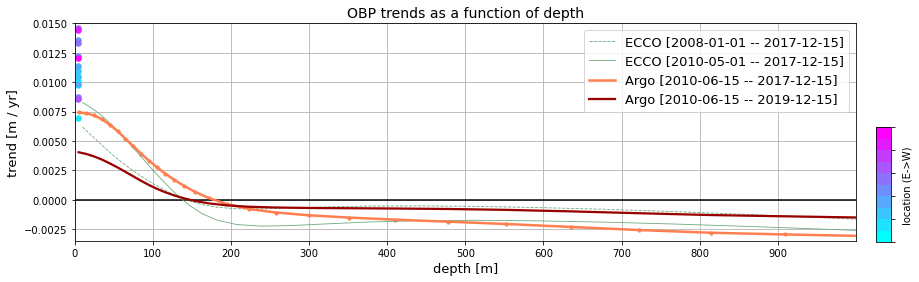

In [77]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='-')

cmap = mpl.cm.get_cmap('cool',10)
clow = 0; chigh = 1; 
norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)
tg_trends = np.array([0.01010977, 0.00977133, 0.01054144, 0.00695134, 0.01096931, 0.01043873, 0.00982837, 0.01140618, 0.01356605, 0.01220623,
       0.00875021, 0.01335275, 0.01461547, 0.00856436, 0.02142472, 0.02116908, 0.01556622, 0.01439639, 0.01205811])
for i in range(len(tg_trends)):
    ax.scatter(4,tg_trends[i],s=30,color=[cmap((i)/len(tg_trends))],zorder=2)
cbpos = [0.92, 0.12, 0.015, 0.4]; cax = f.add_axes(cbpos); 
fc = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label='location (E->W)')   
fc.ax.set_yticklabels([''])

ax.plot(ds_ecco_landerer.depth,ds_ecco_landerer.p_test,label='ECCO [2008-01-01 -- 2017-12-15]', color='#71AB82',linestyle='--', linewidth=0.85)
ax.plot(ds_ecco_landerer.depth,ds_ecco_landerer.p_test8,label='ECCO [2010-05-01 -- 2017-12-15]', color='#71AB82', linewidth=0.85)
ax.plot(-1*v_cell_z.data, p_test, color='#FF7F50', linewidth=2.5, label='Argo [' + t_s[0:10] + ' -- ' + t_e[0:10] + ']')
ax.scatter(-1*v_cell_z.data, p_test, color='#FF7F50', s=10)
ax.plot(-1*v_cell_z.data, p_l_test, color='#990000', linewidth=2.25, label='Argo [' + t_l_s[0:10] + ' -- ' + t_l_e[0:10] + ']')
ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=13)
ax.set_ylabel('trend [m / yr]',fontsize=13); ax.set_ylim([-0.0035, 0.015]);
ax.grid(); ax.set_title('OBP trends as a function of depth',fontsize=14); ax.legend(fontsize=13)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/argo_landerer_w_tg.jpg', dpi=250)

In [53]:
p_test

<xarray.DataArray 'polyfit_coefficients' (zi: 29)>
array([ 0.00741781,  0.00735035,  0.00716689,  0.00684046,  0.00637276,
        0.0058199 ,  0.00518541,  0.0045479 ,  0.00390959,  0.00331323,
        0.00275335,  0.0022218 ,  0.00170378,  0.00118137,  0.00064842,
        0.00011782, -0.00037202, -0.00078644, -0.00109233, -0.00133033,
       -0.00152306, -0.00169844, -0.00187188, -0.00207088, -0.00231888,
       -0.00258407, -0.00281454, -0.00296113, -0.00308856])
Coordinates:
    degree   int64 1
  * zi       (zi) float64 -5.0 -15.0 -25.0 -35.0 ... -814.5 -909.7 -1.007e+03